In [74]:
import sys
sys.path.append('/Users/paolamartire/shocks')

import numpy as np
import matplotlib.pyplot as plt

from grid_maker import make_grid
from Utilities.operators import the_nearest
from scipy.optimize import fsolve
from shock_zone import shock_direction


In [75]:
num = 45
middle_zidx = 22

In [76]:
def the_nearest_inzone(x_zone, y_zone, z_zone, xyz):
    # find the point in the shock zone nearest to xyz
    temp = 1e8
    for idx in range(len(x_zone)):
        point = np.array([x_zone[idx], y_zone[idx], z_zone[idx]])
        dist = np.linalg.norm(xyz - point)
        if dist < temp:
            temp = dist
            final_idx = idx

    return final_idx, point

In [77]:
def shock_surface(x_array, y_array, z_array, Tgrid, x_zone, y_zone, z_zone, div, dir, Tzone):
    dx = x_array[1] - x_array[0]
    surface_mach = []
    surface_x = []
    surface_y = []
    surface_z = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        print(idx)
        point = [x_zone[idx], y_zone[idx], z_zone[idx]]
        div_v = div[idx]
        dir_sh = dir[idx]

        # you loop till you reach the first cell outside the shock zone
        check_zone = 0
        while check_zone < dx:
            # along shock direction to the POST shock 
            new_point = point - np.multiply(dir_sh,dx)
            # find the new point and its nearest points in the grid and in the shock zone
            i,j,k, nearest  = the_nearest(x_array, y_array, z_array, new_point, dx, 'point')
            next_idx, nearest_zone = the_nearest_inzone(x_zone, y_zone, z_zone, new_point)
            div_next = div[next_idx]
            dir_next = dir[next_idx]

            # if lower div v, you discard the ray. You break the while and don't save the point.
            if div_next < div_v:
                check_zone = 1e4
                print('div lower')
                continue

            # if opposite direction in shocks, discard the ray
            if np.dot(dir_sh, dir_next) < 0:
                check_zone = dx - 1
                print('opposite dir')
                continue

            check_zone = np.linalg.norm(nearest - nearest_zone)
            point = nearest
            
        if check_zone < 1e3:
            Tpre = Tgrid[i,j,k]
            Tpost = Tzone[next_idx]
            
            # check if the T jump from Tpre and Tpost is the same as the initial shock direction
            last_shockdir = shock_direction(x_array, y_array, z_array, Tgrid, [i,j,k])
            if np.dot(last_shockdir, dir_sh) > 0:
                surface_x.append(x_zone[idx])
                surface_y.append(y_zone[idx])
                surface_z.append(z_zone[idx])

                def temperature_bump(mach):
                    gamma = 5/3
                    to_solve =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2) - Tpost/Tpre
                    return to_solve
                
                mach = fsolve(temperature_bump, 1)
                surface_mach.append(mach)
            else:
                print('other shock dir')
        
        else:
            print('no mach')

    return surface_mach, surface_x, surface_y, surface_z


In [78]:
# Import data
shockzone = np.loadtxt(f'shockzone_zidx{middle_zidx}.txt')
shockdir = np.loadtxt(f'shockdir_zidx{middle_zidx}.txt')

x_zone = shockzone[0]
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [79]:
# make the grid
_, gridded_den, gridded_T, gridded_P, gridded_Vx, gridded_Vy, gridded_Vz, gridded_V, gridded_Rcell, x_radii, y_radii, z_radii = make_grid(num)


all T=0, bro. CHANGE!
Tree built!


In [80]:
surface_mach, surface_x, surface_y, surface_z = shock_surface(x_radii, y_radii, z_radii, gridded_T, x_zone, y_zone, z_zone, div, dir, Tzone)

0
div lower
no mach
1
div lower
no mach
2
3
div lower
no mach
4
div lower
no mach
5
div lower
no mach
6
div lower
no mach
7
div lower
no mach
8
div lower
no mach
9
div lower
no mach
10
div lower
no mach
11
12
div lower
no mach
13
div lower
no mach
14
div lower
no mach
15
div lower
no mach
16
div lower
no mach
17
div lower
no mach
18
div lower
no mach
19
div lower
no mach
20
div lower
no mach
21
div lower
no mach
22
div lower
no mach
23
div lower
no mach
24
div lower
no mach
25
26
div lower
no mach
27
div lower
no mach
28
div lower
no mach
29
div lower
no mach
30
31
div lower
no mach
32
33
34
35
div lower
no mach
36
div lower
no mach
37
div lower
no mach
38
div lower
no mach
39
div lower
no mach
40
div lower
no mach
41
div lower
no mach
42
div lower
no mach
43
div lower
no mach
44
div lower
no mach
45
div lower
no mach
46
div lower
no mach
47
div lower
no mach
48
49
50
51
52
53
54
55
56
57
div lower
no mach
58
div lower
no mach
59
div lower
no mach
60
div lower
no mach
61
div lower
no m

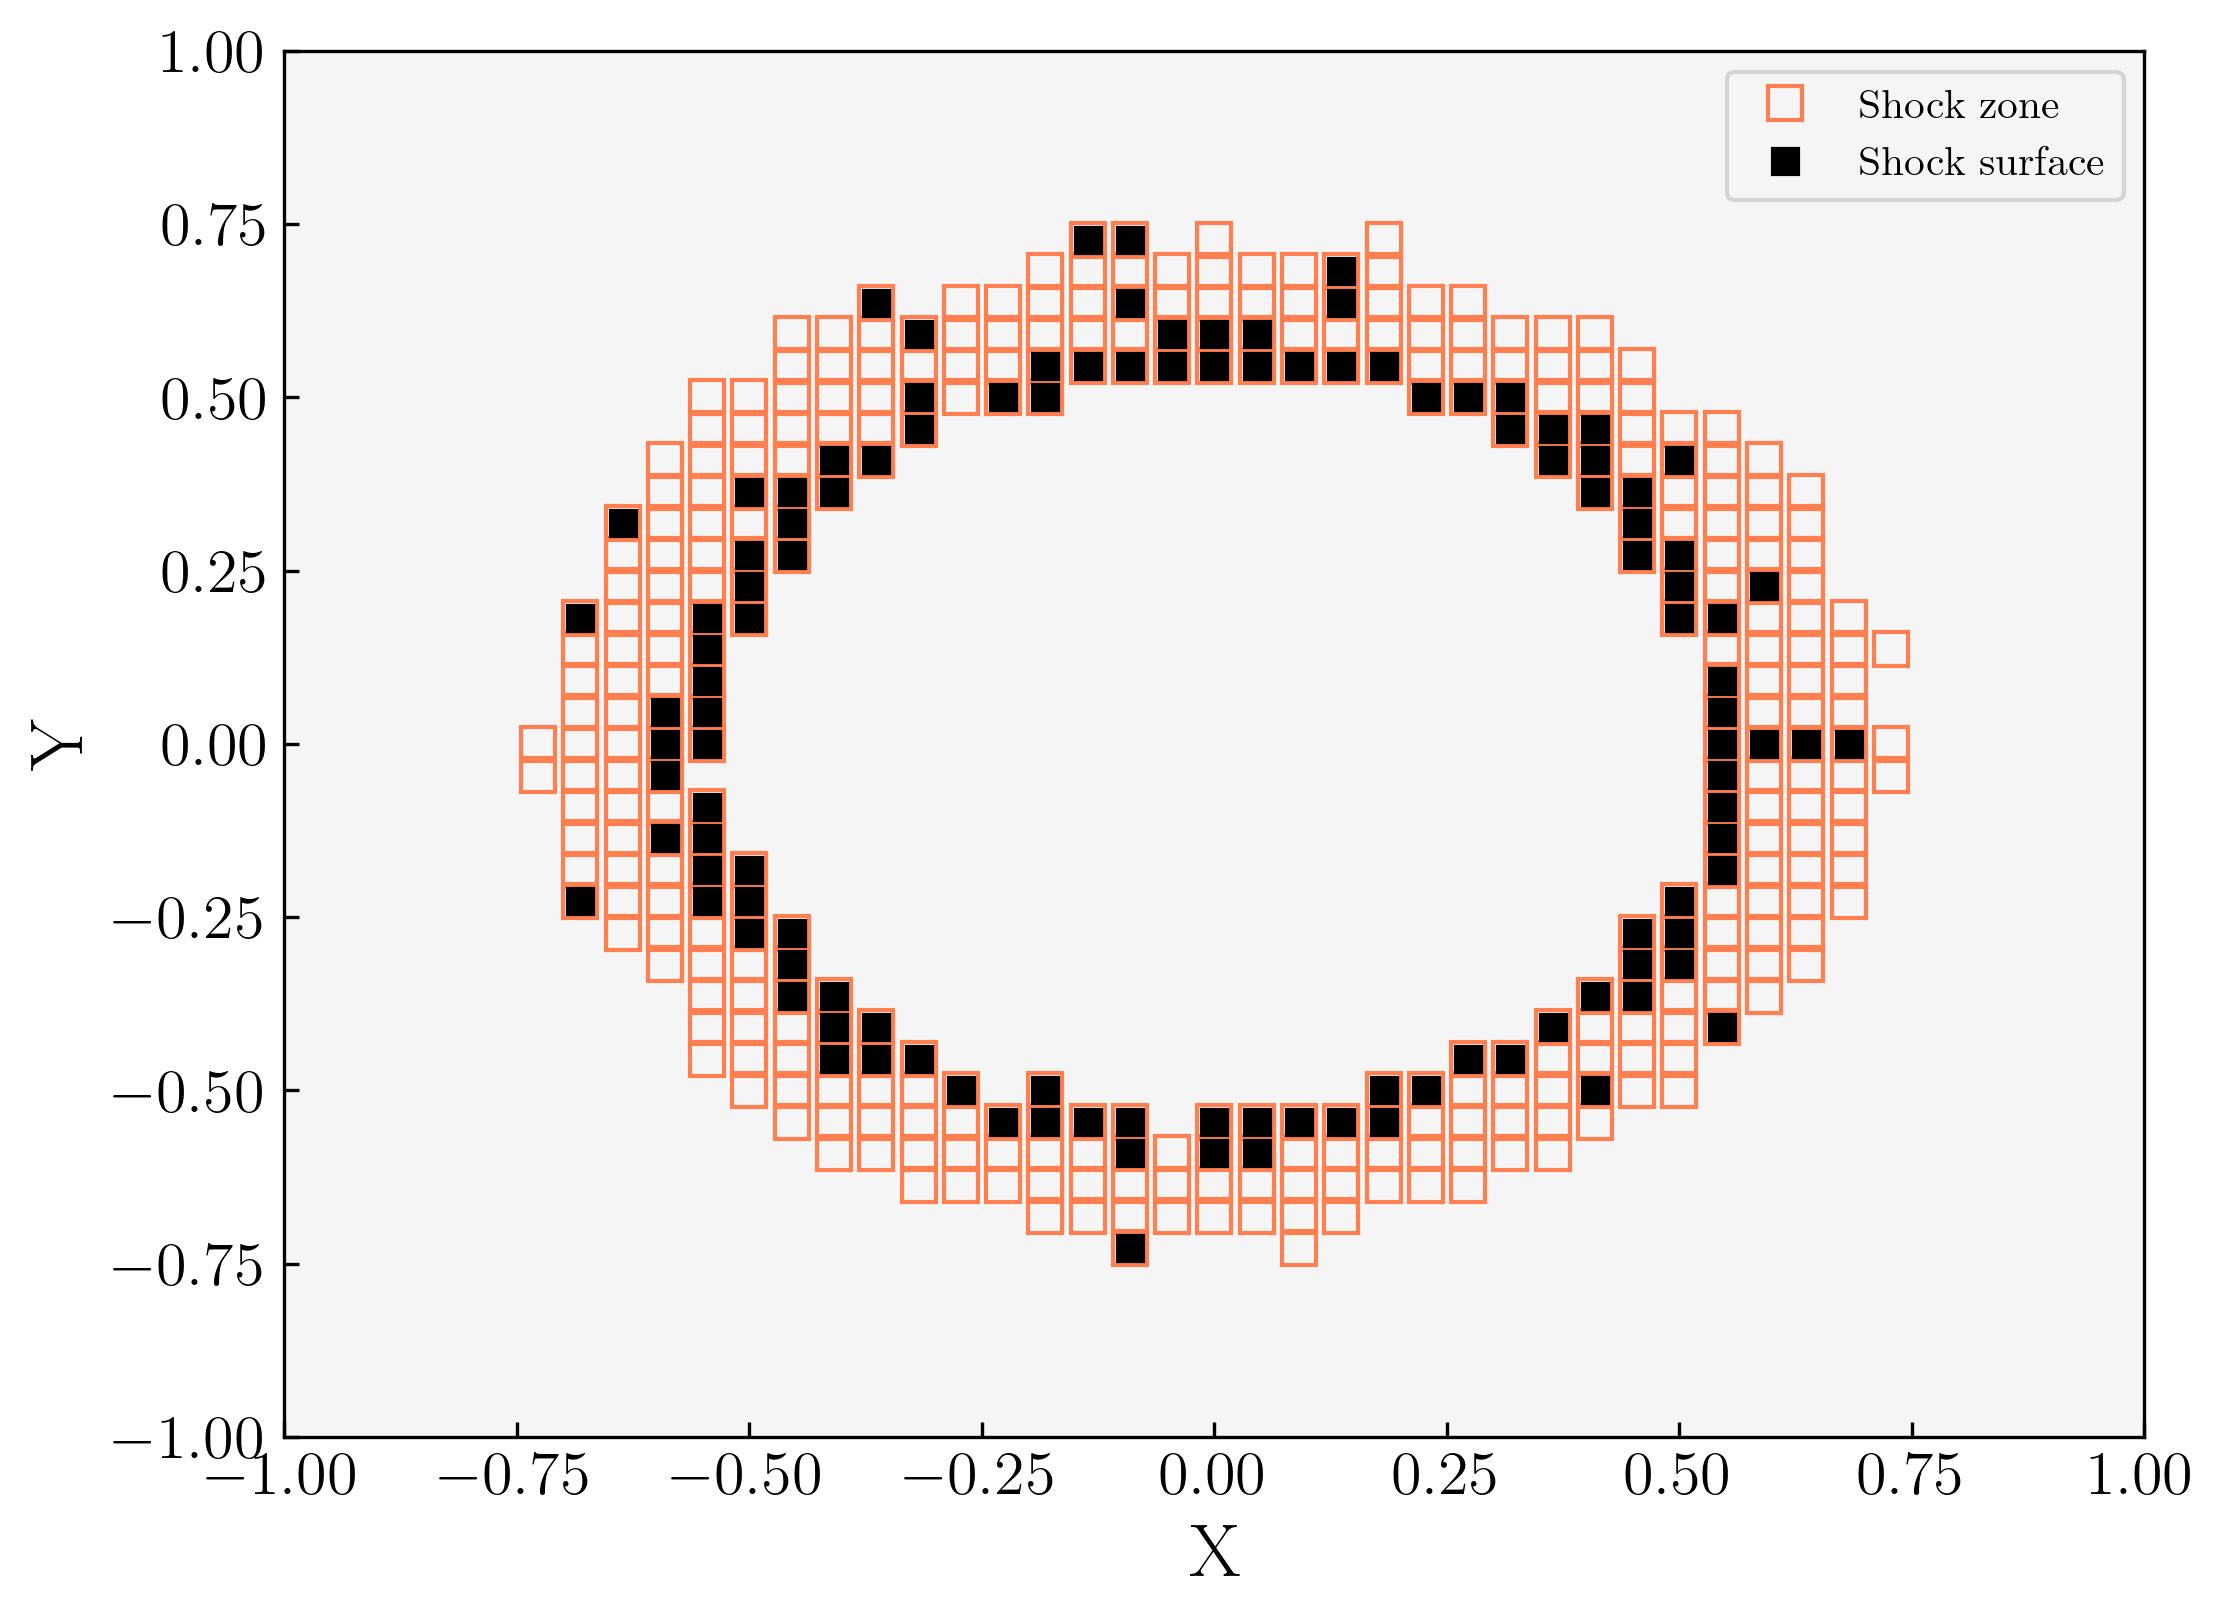

In [81]:
plt.plot(x_zone, y_zone, 'ks', markerfacecolor='none', ms = 8, markeredgecolor='coral', label = 'Shock zone')
plt.plot(surface_x, surface_y, 'ks', markerfacecolor='k', ms = 6, markeredgecolor='k',  label = 'Shock surface')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.legend()
plt.savefig(f'Figs/shocksurface_zidx{middle_zidx}.png')